In [1]:
# Import
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Prepare data for training

def prepare_data(ticker):
    hm_days = 30
    df = pd.read_csv('sp500_joined_closes.csv', index_col = 0)
    
    data = df[ticker]
    data = data.dropna(how='any').values
    num = data.shape[0]
    
    X = np.empty((0, hm_days), int)
    Y = np.array([])
      
    for i in range(num - hm_days - 1):
        X = np.vstack((X, data[i:i+hm_days]))
        Y = np.append(Y, data[i+hm_days])
    return X, Y
    

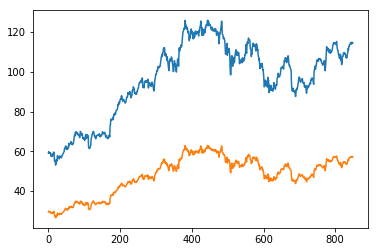

In [24]:
ticker = 'AAPL'

X, Y = prepare_data(ticker)

# Dimensions of dataset
n = X.shape[0]
p = X.shape[1]


# Training and test data
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end
test_end = n

X_train = X[np.arange(train_start, train_end)]
y_train = Y[np.arange(train_start, train_end)]
X_test = X[np.arange(test_start, test_end)]
y_test = Y[np.arange(test_start, test_end)]

#     Scale data
#     scaler = MinMaxScaler(feature_range=(-1, 1))
#     scaler.fit(y_train)

#     X_train = scaler.transform(X_train)
#     y_train = scaler.transform(y_train)
#     X_test = scaler.transform(X_test)
#     y_test = scaler.transform(y_test)

# Number of stocks in training data
n_stocks = X_train.shape[1]

# Neurons
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128

# Session
net = tf.InteractiveSession()

# Placeholder
X = tf.placeholder(dtype=tf.float32, shape=[None, n_stocks])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

# Initializers
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg", distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

# Hidden weights
W_hidden_1 = tf.Variable(weight_initializer([n_stocks, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))
W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3, n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

# Output weights
W_out = tf.Variable(weight_initializer([n_neurons_4, 1]))
bias_out = tf.Variable(bias_initializer([1]))

# Hidden layer
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3, W_hidden_4), bias_hidden_4))

# Output layer (transpose!)
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

# Cost function
mse = tf.reduce_mean(tf.squared_difference(out, Y))

# Optimizer
opt = tf.train.AdamOptimizer().minimize(mse)

# Init
net.run(tf.global_variables_initializer())

# Setup plot
plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test * 0.5)
plt.show()

# Fit neural net
batch_size = 256
mse_train = []
mse_test = []


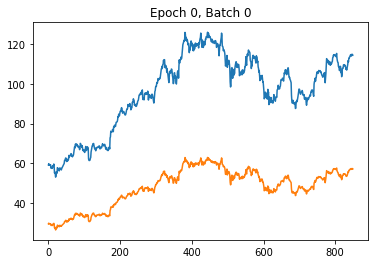

In [25]:
def show(y_test1, y_test2, e, i):
    plt.ion()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    line1, = ax1.plot(y_test1)
    line2, = ax1.plot(y_test2)
    plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
    file_name = os.getcwd() + '/img/epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
    plt.savefig(file_name)
    plt.show()
    
show(y_test, y_test * 0.5, 0, 0)

In [26]:
# Run
epochs = 10

for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]
    
    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        # Run optimizer with batch
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

        # Show progress
        if np.mod(i, 50) == 0:
            # MSE train and test
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
            print('MSE Train: ', mse_train[-1])
            print('MSE Test: ', mse_test[-1])
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))

            # Prediction
            pred = net.run(out, feed_dict={X: X_test})
            print("")
                        
#             show(y_test, np.squeeze(pred), e, i)
            
#             break
#     break
mse_test.append(net.run(mse, feed_dict={X: X_test, Y: y_test}))
print('MSE Test: ', mse_test[-1])
            

MSE Train:  61.542587
MSE Test:  1092.9628

MSE Train:  1.7040067
MSE Test:  17.36388

MSE Train:  3.4828918
MSE Test:  53.237022

MSE Train:  4.233041
MSE Test:  68.0289

MSE Train:  2.3094156
MSE Test:  33.734665

MSE Train:  1.0796349
MSE Test:  11.8244705

MSE Train:  2.2230828
MSE Test:  33.171864

MSE Train:  0.9603208
MSE Test:  11.305812

MSE Train:  0.7590754
MSE Test:  8.246173

MSE Train:  0.941444
MSE Test:  11.884559

MSE Test:  11.170203


In [27]:
def showPred(y_test1, y_test2):
    plt.ion()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    line1, = ax1.plot(y_test2)
    line2, = ax1.plot(y_test1)
#     plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
#     file_name = os.getcwd() + '/img/epoch_' + str(e) + '_batch_' + str(i) + '.jpg'
#     plt.savefig(file_name)

    plt.show()
    

(4278,)
<class 'numpy.ndarray'>


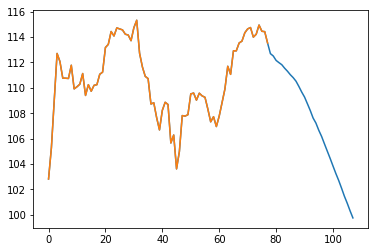

In [53]:
df = pd.read_csv('sp500_joined_closes.csv', index_col = 0)
data = df[ticker]
data = data.dropna(how='any').values
    
old = data
    

f_horizon = 30

print(data.shape)
print(type(X_test))

for i in range(f_horizon):
    X_test = data[-30:].reshape(-1, 30)
    pred = net.run(out, feed_dict={X: X_test})
#     print(pred)
    data = np.append(data, pred)

showPred(old[4200:], data[4200:])
    
